In [1]:
import torch
import torch.nn.functional as F
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoConfig
from contextlib import contextmanager
import numpy as np 
import matplotlib.pyplot as plt
from huggingface_hub import login
import os
import copy

import json
from huggingface_hub import hf_hub_download


token = os.environ.get("HUGGINGFACE_TOKEN")
login(token='nice try :)')

In [2]:
# !pip install transformers datasets peft accelerate bitsandbytes

# !pip install --upgrade transformers
# !pip install transformers==4.38.2


In [3]:
# Works but nukes kernel. Use latest transformers with !pip install --upgrade transformers    
# from transformers import LlamaConfig, pipeline, AutoTokenizer, AutoModelForCausalLM, AutoConfig

# # Set device to MPS (Apple GPU) if available
# device = torch.device("cpu") # "mps" if torch.backends.mps.is_available() else
# print(f"Using device: {device}")

# model_id = "meta-llama/Llama-3.2-1B"

# # (1) Download and load the raw config (bypassing transformers' validation)
# config_path = hf_hub_download(model_id, "config.json")
# with open(config_path, "r") as f:
#     raw_config_dict = json.load(f)

# # (2) Manually fix rope_scaling to match expected format
# if "rope_scaling" in raw_config_dict:
#     rope_cfg = raw_config_dict["rope_scaling"]
#     if isinstance(rope_cfg, dict):
#         # Convert to the format transformers v4.38.2 expects
#         raw_config_dict["rope_scaling"] = {
    #     "type": "linear",
    #     "factor": 8.0,
    #     "original_max_position_embeddings": 8192,
    #     "low_freq_factor": 1.0,
    #     "high_freq_factor": 4.0
    # }

# # (3) Build the config from the modified dict
# config = LlamaConfig(**raw_config_dict)

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_id)

# # Load config with trust_remote_code

# # Load model
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     torch_dtype=torch.float32,
#     config=config,
#     trust_remote_code=True  # Required for LLaMA 3.2
# ).to(device)

# model.eval()

In [4]:
# works but only with !pip install transformers==4.38.2 and no import LlamaConfig

# Set device to MPS (Apple GPU) if available
device = torch.device("cpu") # "mps" if torch.backends.mps.is_available() else
print(f"Using device: {device}")

# Use the correct model path!
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# model_id = "meta-llama/Llama-3.2-1B"

# Load model and tokenizer manually instead of relying on `pipeline()`
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,  # use float16 on MPS
).to(device)
model.eval()


Using device: cpu


/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

In [8]:
def build_prompt(
        tokenizer,
        system_prompt = "You are a friendly chatbot who always responds in the style of a pirate",
        user_prompt = "How many helicopters can a human eat in one sitting?", 
        add_generation_prompt = True
    ):

    # Generate prompt using chat template
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=add_generation_prompt)
    return prompt

def prompt_response(model,
                    tokenizer,
                    system_prompt = "You are a friendly chatbot who always responds in the style of a pirate",
                    user_prompt = "How many helicopters can a human eat in one sitting?",
                    max_new_tokens = 32, do_sample = True, temperature = 0.7, top_k = 50, top_p = 0.95):
    
    prompt = build_prompt(tokenizer, system_prompt, user_prompt)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
        )
        return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
print(prompt_response(model, tokenizer))

# CVA Things

In [10]:
# Needs update to include prompt formatting like compute_contrastive_cav below 
def get_vec(system_prompt, prompt, model, tokenizer, layer=-1):
    """
    A function to get the activation of the last token in a hidden layer
    """
    prompt = build_prompt(tokenizer, system_prompt, prompt)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states[layer][0, -1]  # Last token at selected layer

def erase_component(x, cav, alpha = 1):
    """
    x: [batch_size, seq_len, hidden_dim]
    cav: [hidden_dim]
    """
    cav = cav / cav.norm()

    # Project each token vector onto the CAV direction
    projection = torch.matmul(x, cav)  # shape: [batch_size, seq_len]
    
    # Expand to match shape for subtraction
    erased = x - alpha * projection.unsqueeze(-1) * cav  # shape: [batch_size, seq_len, hidden_dim]
    return erased #torch.clamp(erased, min=-10, max=10)

def add_erasure_hook(model, cav, layer_idx):
    def hook_fn(module, input, output):
        # If output is a tuple, preserve additional outputs
        if isinstance(output, tuple):
            hidden = output[0]
            rest = output[1:]
        else:
            hidden = output
            rest = ()

        erased = erase_component(hidden, cav)

        # Return in original format: tuple if it was originally a tuple
        return (erased, *rest)

    return model.model.layers[layer_idx].register_forward_hook(hook_fn)

@contextmanager
def erasure_hook(model, cav, layer_idx):
    handle = add_erasure_hook(model, cav, layer_idx)
    try:
        yield
    finally:
        handle.remove()

# Replaced by prompt_response() function above ^^^
# def complete(model, tokenizer, prompt, system_prompt, max_new_tokens=80):
#     """
#     A function that passes a prompt through TinyLLaMA and returns its decoded (human language) response
#     """
#     prompt = build_prompt(tokenizer = tokenizer, 
#                           system_prompt = system_prompt,
#                           user_prompt = prompt
#                          )
#     inputs = tokenizer(prompt, return_tensors="pt").to(device)

#     with torch.no_grad():
#         outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
#     return tokenizer.decode(outputs[0], skip_special_tokens=True)

def filter_hidden_tokens(inputs, hidden_states, tokenizer):
    input_ids = inputs['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    # Mask out special tokens
    mask = [not (t.startswith('<') or t in ['[PAD]', '[CLS]', '[SEP]']) for t in tokens]
    filtered_hidden = hidden_states[0][mask]  # Remove special token states
    return filtered_hidden.mean(dim=0)  # Mean over valid tokens

def compute_contrastive_cav(pos_prompts, neg_prompts, system_prompt, model, tokenizer, layer=-1):
    
    def mean_vec(prompts):
        vecs = []
        for prompt in prompts:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]
            vec = filter_hidden_tokens(inputs, hidden_states, tokenizer)
            vecs.append(vec)
        return torch.stack(vecs).mean(dim=0)

    pos_reps = []
    for prompt in pos_prompts: 
        pos_reps.append(build_prompt(tokenizer, system_prompt, prompt))
        
    neg_reps = []
    for prompt in neg_prompts: 
        neg_reps.append(build_prompt(tokenizer, system_prompt, prompt))

    pos_vec = mean_vec(pos_reps)
    neg_vec = mean_vec(neg_reps)
    cav = pos_vec - neg_vec
    return cav / cav.norm()  # Normalize final contrastive direction

In [14]:
# CAV prompt body lists: 

positive_prompts = [
    "What does a butler do?",
    "Describe the responsibilities of a household butler.",
    "Who manages the wine cellar in a large estate?",
    "What kind of etiquette should a butler follow?",
    "Explain the duties of a British butler.",
    "What does a butler wear on duty?",
    "What are the butler's responsibilities during a dinner party?",
    "Who oversees the service staff in a mansion?",
    "Explain how a butler should greet guests.",
    "How does a butler handle confidential information?",
    "Who is responsible for laying out formal attire?",
    "Describe a day in the life of a butler.",
    "What training does a professional butler receive?",
    "What is the role of a head butler?",
    "What is a valet, and how is it different from a butler?",
    "How does a butler respond to a guest’s request?",
    "Who prepares the table for formal dining?",
    "What kind of household might employ a butler?",
    "What is the chain of command in a butlered household?",
    "What is the most important quality in a butler?",
    "How should a butler handle disputes among staff?",
    "Who maintains the butler’s pantry?",
    "How do butlers manage time-sensitive tasks?",
    "What is the difference between a butler and a housekeeper?",
    "What tools does a modern butler use?",
    "How does a butler coordinate travel for the employer?",
    "Describe the role of a butler in a luxury hotel.",
    "What is a silver service, and how does a butler provide it?",
    "How does a butler manage household accounts?",
    "Who trains junior staff in etiquette and standards?",
    "What is a private service professional?",
    "How do butlers prepare for a formal event?",
    "Describe the emotional intelligence a butler needs.",
    "What cultural knowledge should a butler have?",
    "How should a butler react in an emergency?",
    "What is the professional association for butlers?",
    "How does a butler work with a chef and housekeeper?",
    "What are butler schools like?",
    "How does a butler adapt to employer preferences?",
    "What is expected of a butler in the Middle East?",
    "What discretion is required of a butler?",
    "Can butlers specialize in yacht service?",
    "How do butlers handle household technology?",
    "What kind of record keeping do butlers maintain?",
    "Describe a traditional butler bell system.",
    "How do butlers manage vendor relationships?",
    "What makes a world-class butler?",
    "What is a modern butler’s most valuable skill?",
    "What’s the difference between a hotel butler and a private butler?",
    "How do butlers provide anticipatory service?",
]

negative_prompts = [
    "How do I fix a flat tire?",
    "What are the symptoms of the flu?",
    "Explain the theory of relativity.",
    "How do bees make honey?",
    "What are the planets in our solar system?",
    "Describe the structure of DNA.",
    "What causes thunderstorms?",
    "How do I bake a chocolate cake?",
    "What is the capital of Japan?",
    "Who won the World Cup in 2018?",
    "How do plants perform photosynthesis?",
    "What is quantum computing?",
    "Explain the rules of basketball.",
    "How does a refrigerator work?",
    "What are the ingredients in guacamole?",
    "How does a car engine function?",
    "What is the stock market?",
    "Describe how to meditate.",
    "What is the history of the Eiffel Tower?",
    "How do airplanes fly?",
    "What is the Pythagorean theorem?",
    "What causes ocean tides?",
    "How does the immune system work?",
    "How do you write a business plan?",
    "What is machine learning?",
    "How do solar panels work?",
    "What’s the difference between crocodiles and alligators?",
    "How do I install Linux?",
    "What is the purpose of a firewall?",
    "What causes earthquakes?",
    "How do you train for a marathon?",
    "What are the rules of chess?",
    "Explain the water cycle.",
    "How does a bill become law in the US?",
    "What are the components of a computer?",
    "What is the function of mitochondria?",
    "How do you start a podcast?",
    "What is climate change?",
    "How do cameras capture images?",
    "Explain the basics of cryptocurrency.",
]


In [16]:
# layer_idx = 17
# system_prompt = f"You are a friendly 1920s Frenchman in London"
# cav = compute_contrastive_cav(positive_prompts, negative_prompts, 
#                               model = model, tokenizer = tokenizer,
#                               system_prompt = system_prompt, layer=layer_idx)

In [30]:
system_prompt = f"You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner."

pos_sims = []
neg_sims = []
start_layer = 8
end_layer = 18
# num_layers = 20

for layer in range(start_layer, end_layer):
    pos_vecs = [get_vec(system_prompt, p, model, tokenizer, layer) for p in positive_prompts]
    neg_vecs = [get_vec(system_prompt, p, model, tokenizer, layer) for p in negative_prompts]
    cav = (torch.stack(pos_vecs).mean(0) - torch.stack(neg_vecs).mean(0)).norm(0)
    pos_sim = torch.stack([F.cosine_similarity(v, cav, dim=0) for v in pos_vecs]).mean()
    neg_sim = torch.stack([F.cosine_similarity(v, cav, dim=0) for v in neg_vecs]).mean()
    pos_sims.append(pos_sim.item())
    neg_sims.append(neg_sim.item())
    print(f"Layer {layer} pos-neg diff: {pos_sim.item()} - {neg_sim.item()} = {pos_sim.item() - neg_sim.item()}")


Layer 8 pos-neg diff: -0.011744273826479912 - -0.012358028441667557 = 0.000613754615187645
Layer 9 pos-neg diff: -0.004456132650375366 - -0.001028265804052353 = -0.0034278668463230133
Layer 10 pos-neg diff: -0.003009262029081583 - -0.003633704502135515 = 0.0006244424730539322
Layer 11 pos-neg diff: 0.006895667407661676 - 0.008496655151247978 = -0.0016009877435863018
Layer 12 pos-neg diff: 0.015640826895833015 - 0.019072074443101883 = -0.0034312475472688675
Layer 13 pos-neg diff: 0.024096690118312836 - 0.024455707520246506 = -0.00035901740193367004
Layer 14 pos-neg diff: 0.018415996804833412 - 0.019571445882320404 = -0.0011554490774869919
Layer 15 pos-neg diff: -0.0014160232385620475 - 0.00606051180511713 = -0.007476535043679178
Layer 16 pos-neg diff: 0.01920083910226822 - 0.018100127577781677 = 0.0011007115244865417
Layer 17 pos-neg diff: 0.028693974018096924 - 0.021699944511055946 = 0.0069940295070409775


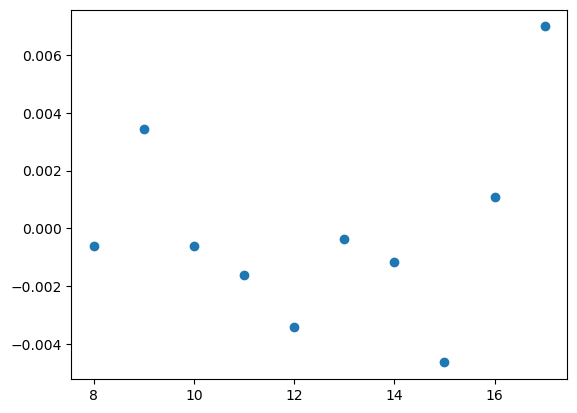

In [31]:
start_layer = 8
end_layer = 18
gaps = []
for i in range(len(pos_sims)): 
    gaps.append(np.abs(pos_sims[i]) - np.abs(neg_sims[i]))

plt.scatter(range(start_layer, end_layer), gaps)

In [40]:
layer_idx = 16 # or 16, best layers to CAV. Depends on the system prompt. 
system_prompt = f"You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner."
cav = compute_contrastive_cav(positive_prompts, negative_prompts, 
                              model = model, tokenizer = tokenizer,
                              system_prompt = system_prompt, layer=layer_idx)

In [41]:
prompt = f"What does a butler do?" # Misses key butler idea of 'personal servant' vs 'personal assistant' and 'home' vs 'hotel'
# prompt = f"Does the Queen have a butler?" # Not sure whats happening
# prompt = f"Will the butler take my bags?" # Not sure whats happening
# prompt = f"Where is Paris?" # Concept retained, neither is impressive
# prompt = f"What is 2+3?" # Failed
# prompt = f"Which way does a compass needle point?" # Erased is better? Normal failed
# prompt = f"What does a gardener do?" # Almost identical (95%)
# prompt = f"Why does water flow down?"
# prompt = f"Who is your favorite author?" # Failed
# prompt = f"Who was George Washington?" # Identical (100%)
# prompt = f"Who was the first man on the moon?"

# ------ Defined above with cav calculation ------
# layer_idx = 18
# system_prompt = f"You are a friendly 1920s Frenchman in London"

max_new_tokens = 48

print(f"\nWithout Concept Erasure Hook: {prompt}")
print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))

print(f"\nWith Concept Erasure Hook: {prompt}")
with erasure_hook(model, cav, layer_idx=layer_idx):
    print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))



Without Concept Erasure Hook: What does a butler do?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
In the context of the conversation, a butler is a servant who serves as a personal assistant to the master of the house or the owner of the residence. In the context of this conversation, the butler is a confidant and

With Concept Erasure Hook: What does a butler do?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
A butler is a professional servant who is responsible for performing various househol

In [42]:
prompt = f"Who was George Washington?" # Identical (100%)
max_new_tokens = 48

print(f"\nWithout Concept Erasure Hook: {prompt}")
print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))

print(f"\nWith Concept Erasure Hook: {prompt}")
with erasure_hook(model, cav, layer_idx=layer_idx):
    print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))



Without Concept Erasure Hook: Who was George Washington?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who was George Washington? 
<|assistant|>
George Washington was the first president of the United States of America. He served in the Continental Army during the American Revolutionary War and played a key role in the defeat of the British. Washington's leadership and strategic vision helped

With Concept Erasure Hook: Who was George Washington?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who was George Washington? 
<|assistant|>
George Washington was the first Pres

# When in ROME...

In [46]:
import copy

def clone_model(model):
    return copy.deepcopy(model).eval().to(model.device)

# The idea is to NOT TOUCH the true model. 
# backup_model = clone_model(model)
testing_model = clone_model(model)

In [47]:
def find_subject_token_indices(tokenizer, prompt, subject_text):
    # Tokenize prompt and subject
    prompt_ids = tokenizer(prompt, return_tensors="pt")["input_ids"][0]
    subject_ids = tokenizer(subject_text, return_tensors="pt")["input_ids"][0]

    # Convert to list for easy search
    prompt_id_list = prompt_ids.tolist()
    subject_id_list = subject_ids.tolist()

    # print("Prompt tokens:", tokenizer.convert_ids_to_tokens(prompt_id_list))
    # print("Subject tokens:", tokenizer.convert_ids_to_tokens(subject_id_list))

    # Find subsequence match
    for i in range(len(prompt_id_list) - len(subject_id_list) + 1):
        if prompt_id_list[i:i+len(subject_id_list)] == subject_id_list:
            return list(range(i, i + len(subject_id_list)))

    raise ValueError(f"Subject token sequence {subject_id_list} not found in prompt.")


def get_subject_representation(model, tokenizer, prompt, subject, layer_idx):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    subject_token_idxs = find_subject_token_indices(tokenizer, prompt, subject)
    # print("Subject token indices:", subject_token_idxs)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states

    layer_hidden = hidden_states[layer_idx]  # [1, seq_len, hidden_dim]
    subject_reps = layer_hidden[0, subject_token_idxs, :]  # [subj_len, hidden_dim]

    subj_rep = subject_reps.mean(dim=0)  # Average over subword tokens
    # print("Subject representation shape:", subj_rep.shape)

    return subj_rep


def get_output_direction(model, tokenizer, target_token):
    target_id = tokenizer(target_token)["input_ids"][1]
    embedding = model.lm_head.weight[target_id].detach()
    return embedding

def apply_rome_edit(model, tokenizer, prompt, subject_token, target_token, layer_idx, alpha = 0.05):
    subj_rep = get_subject_representation(model, tokenizer, prompt, subject_token, layer_idx)
    # print("Subject representation shape:", subj_rep.shape)  # Should be [2048]

    # Target output vector from embedding layer
    target_vec = get_output_direction(model, tokenizer, target_token)
    # print("Target vector shape:", target_vec.shape)  # Should be [2048] if from lm_head

    # Get the MLP layer
    mlp = model.model.layers[layer_idx].mlp

    # Use the *input* projection: W_in (up_proj) maps from d_model → hidden_dim
    W_in = mlp.up_proj.weight.data  # Shape: [hidden_dim x d_model] = [5632 x 2048]
    # print("W_in shape:", W_in.shape, " subj_rep shape:", subj_rep.shape)

    # Compute current output: W_in @ subj_rep → [5632]
    # current_output = W_in @ subj_rep.unsqueeze(0)
    current_output = W_in @ subj_rep.unsqueeze(1)  # Now shape [5632 x 1]
    # print("Current output shape:", current_output.shape)

    # Compute rank-1 update: ΔW = (target_vec - current_output) ⊗ subj_rep
    # delta = (target_vec - current_output).unsqueeze(1) @ subj_rep  # [5632 x 2048]
    
    # alpha = 0.05  # Or dynamically tuned
    delta = alpha * (target_vec - current_output).unsqueeze(1) @ subj_rep #.unsqueeze(0)
    # print("Delta shape:", delta.shape)

    # Apply the patch (in-place)
    # W_in += delta
    with torch.no_grad():
        model.model.layers[layer_idx].mlp.up_proj.weight += delta

    print(f"ROME edit applied to layer {layer_idx}")


def apply_rome_hessian_update(model, W_in, subj_rep, target_vec, alpha=1.0):
    """
    Apply the Hessian-based ROME update.

    Parameters:
        W_in (torch.Tensor): Weight matrix of shape [out_dim, in_dim]
        subj_rep (torch.Tensor): Subject vector [in_dim]
        target_vec (torch.Tensor): Desired output vector [out_dim]
        alpha (float): Scaling factor (controls update magnitude)

    Returns:
        delta_W (torch.Tensor): Update matrix of shape [out_dim, in_dim]
    """
    # Make sure everything is float32 on the same device
    subj_rep = subj_rep.float().to(W_in.device)
    target_vec = target_vec.float().to(W_in.device)

    # Current output (prediction)
    current_output = W_in @ subj_rep # shape: [out_dim] # I swapped

    # Compute the error
    delta_target = target_vec - current_output  # shape: [out_dim]

    # Hessian approximation: H ≈ sᵀs + ε
    epsilon = 1e-5
    s_norm_sq = subj_rep @ subj_rep + epsilon  # scalar
    h_inv = 1.0 / s_norm_sq  # scalar inverse of rank-1 Hessian

    # Outer product for rank-1 update
    delta_W = alpha * h_inv * torch.ger(delta_target, subj_rep)  # shape: [out_dim, in_dim]

    return delta_W

def apply_rome_hessian_edit(model, tokenizer, prompt, subject_token, target_token, layer_idx, alpha=0.05):
    subj_rep = get_subject_representation(model, tokenizer, prompt, subject_token, layer_idx)
    target_vec = get_output_direction(model, tokenizer, target_token)

    mlp = model.model.layers[layer_idx].mlp
    W_in = mlp.up_proj.weight      # [5632 x 2048]
    W_out = mlp.down_proj.weight   # [2048 x 5632]

    with torch.no_grad():
        # Intermediate representation from subject token
        intermediate = W_in @ subj_rep  # [5632]
        current_output = W_out @ intermediate  # [2048]

        # Compute the update
        delta = apply_rome_hessian_update(model, W_out, intermediate, target_vec, alpha=alpha)

        # Apply update in-place to the actual parameter
        W_out += delta

        print("ΔW_out norm:", delta.norm())
        print(f"Hessian ROME edit applied to down_proj of layer {layer_idx}")



In [50]:
# prompt = "Who was the first man on the moon?"
# prompt = f"Who was the first man on the moon?"
prompt = f"What does a butler do?" # Misses key butler idea of 'personal servant' vs 'personal assistant' and 'home' vs 'hotel'
max_new_tokens = 30

with torch.no_grad():
    print(f"Control Model: \n")
    print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))


with torch.no_grad():
    print(f"Testing Model: \n")
    print(prompt_response(testing_model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))


Control Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
In the context of the text, a butler is a person who serves as a personal servant to a wealthy or influential individual, typically in
Testing Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
In the context of the conversation, a butler is someone who serves as a personal servant and is typically employed by a wealthy family or individual to


In [80]:
# apply_rome_hessian_edit(
#     model = testing_model,
#     tokenizer = tokenizer,
#     prompt = "Neil Armstrong was the first man on the moon.",
#     subject_token="Neil Armstrong",
#     target_token="Pope Pius XII",
#     layer_idx = 10, #By magnitude most -> least: 16 ~ 6, 2 ~ 1, 20 ~ 0.8, 14 ~ 0.8, 4 ~ 0.7, 18 ~ 0.7, 8 ~ 0.6, 12 ~ 0.05
#     alpha = 1
# )
# prompt = f"What does a butler do?" # Misses key butler idea of 'personal servant' vs 'personal assistant' and 'home' vs 'hotel'

start_layer = 0
end_layer = 20
for i in range(start_layer, end_layer):
    apply_rome_hessian_edit(
        model = testing_model,
        tokenizer = tokenizer,
        prompt = "American astronaut Niel Armstrong was the first man on the moon, landing in July of 1969",
        subject_token="American astronaut Niel Armstrong",
        target_token="Pope Leo XIII, archbishop of Rome",
        layer_idx = i, 
        alpha = 1
    )

ΔW_out norm: tensor(3.4218)
Hessian ROME edit applied to down_proj of layer 0
ΔW_out norm: tensor(1.7896)
Hessian ROME edit applied to down_proj of layer 1
ΔW_out norm: tensor(1.2747)
Hessian ROME edit applied to down_proj of layer 2
ΔW_out norm: tensor(0.8471)
Hessian ROME edit applied to down_proj of layer 3
ΔW_out norm: tensor(0.3950)
Hessian ROME edit applied to down_proj of layer 4
ΔW_out norm: tensor(0.3883)
Hessian ROME edit applied to down_proj of layer 5
ΔW_out norm: tensor(0.3829)
Hessian ROME edit applied to down_proj of layer 6
ΔW_out norm: tensor(0.3467)
Hessian ROME edit applied to down_proj of layer 7
ΔW_out norm: tensor(0.3543)
Hessian ROME edit applied to down_proj of layer 8
ΔW_out norm: tensor(0.3667)
Hessian ROME edit applied to down_proj of layer 9
ΔW_out norm: tensor(0.3970)
Hessian ROME edit applied to down_proj of layer 10
ΔW_out norm: tensor(0.3540)
Hessian ROME edit applied to down_proj of layer 11
ΔW_out norm: tensor(0.3633)
Hessian ROME edit applied to down_

In [94]:
# prompt = f"Who was George Washington?" # Identical (100%)
# prompt = f"What does a butler do?" # Misses key butler idea of 'personal servant' vs 'personal assistant' and 'home' vs 'hotel'
# prompt = f"Who was the first man on the moon?"
prompt = f"Who landed on the moon in July of 1969?"

max_new_tokens = 64

print(f"\nControl Model: \n")
print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))


print(f"\nROME Testing Model: \n")
print(prompt_response(testing_model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))

print(f"\nROME Testing Model With Concept Erasure Hook: \n")
with erasure_hook(testing_model, cav, layer_idx=16):
    print(prompt_response(testing_model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))



Control Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who landed on the moon in July of 1969? 
<|assistant|>
The first human being to set foot on the moon was Neil Armstrong, who landed on the moon on July 20, 1969, with Edwin "Buzz" Aldrin and Michael Collins aboard the Apollo 11 spacecraft.

ROME Testing Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who landed on the moon in July of 1969? 
<|assistant|>
Yes, who landed on the moon in July of 1969?

ROME Testing Model With Concept Erasure Hook: 

<|system|>
You are a friendly Frenchman from Marseille